In [2]:
import pickle
import numpy as np
import random
random.seed(666)
####################################################################################################
# The datafiles are here: mint.uvt.nl:/roaming/gchrupal/vgs/experiments/flickr8k-segmatch_s3_grl-3/
####################################################################################################

# Load validation sentence data
sent = pickle.load(open("val_sentences.pkl", "rb"))
# Load validation embeddings
emb  = np.load("val_embeddings.npy")

# Shuffle
ix = list(range(len(sent)))
random.shuffle(ix)
sent = [ sent[i] for i in ix]
emb  = emb[np.array(ix)]

You need to install vg in order to run the cell below.

```
git clone git@github.com:gchrupala/vgs.git
cd vgs
python3 setup.py develop --user
```

In [3]:
# Compute scores for paraphrase retrieval
from vg.evaluate import paraphrase_ranking
N = len(sent)
correct = np.zeros((N, N)).astype(bool)

In [4]:
for i in range(N):
    for j in range(N):
        if sent[i]['imgid'] == sent[j]['imgid'] and i != j:
                correct[i, j] = True

In [5]:
result = paraphrase_ranking(emb, correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 20.0
Recall @ 10: 0.1263


In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(emb)
print(pca.explained_variance_)

[0.6780892 0.0992684]


In [7]:
# Results for just the 2D projected embeddings
result = paraphrase_ranking(X, correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 10.0
Recall @ 10: 0.2077


In [8]:
# Results for just the first PC
result = paraphrase_ranking(X[:,:1], correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 536.5
Recall @ 10: 0.0038


In [9]:
# Results for just the second PC
result = paraphrase_ranking(X[:,1:], correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 796.0
Recall @ 10: 0.0019


In [10]:
# Hmm maybe we need euclidean with just a single dim
print("PC1")
result = paraphrase_ranking(X[:,0:], correct, metric='euclidean')
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))
print("PC2")
result = paraphrase_ranking(X[:,1:], correct, metric='euclidean')
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))
print("PC1 PC2")
result = paraphrase_ranking(X[:,:], correct, metric='euclidean')
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))


PC1
Median rank: 10.0
Recall @ 10: 0.217
PC2
Median rank: 25.0
Recall @ 10: 0.0916
PC1 PC2
Median rank: 10.0
Recall @ 10: 0.217


In [11]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


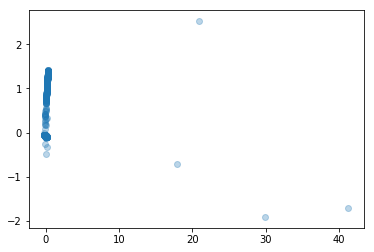

In [12]:
# What does the PCA space look like

pylab.scatter(X[:, 0], X[:,1], alpha=0.3)

In [13]:
# The retrieval scores are pretty decent
# Let's see some nearest neighbors
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(X)
for i in range(0, 1000, 200):
    count = Counter()
    print(sent[i]['raw'])
    for k in range(1, 15):
        j = sim[i].argsort()[-k]
        if i != j:
            print(correct[i][j], sent[j]['imgid'], sent[j]['speaker'], sim[i,j], sent[j]['raw'])
            count.update([sent[j]['imgid']])
    print(count)
    print()
    

A bride folds her arms at a beach .
True 6977 flickr8k_66 1.0 A girl wears a fancy dress and a tiara .
False 6978 flickr8k_11 0.99999994 Someone climbing a rock upside down
True 6977 flickr8k_21 0.9999998 a woman wear a fancy dress and tiara on a beach
False 6978 flickr8k_49 0.99999976 Men try to climb up a large rock .
False 6978 flickr8k_17 0.99999976 A man in red rock climbing .
False 6978 flickr8k_4 0.9999996 Two men are climbing on an interestingly shaped rock feature .
False 6976 flickr8k_92 0.9999993 A young girl in a striped shirt wears a bowl on her head .
False 6976 flickr8k_9 0.99999917 A little girl smiles as she wears a white bowl on the top of her head .
False 6976 flickr8k_111 0.9999976 A young girl sitting at a table with a bowl on her head
False 6979 flickr8k_91 0.9999971 A man poses for a little girl , his arms outstretched , with a large church in the background .
False 6978 flickr8k_5 0.9999932 A person in a red shirt is holding on to a natural formation .
False 697

In [14]:
# How correlated are these components with utterance length?
import scipy.stats
L = np.array([s['audio'].shape[0] for s in sent])
print(scipy.stats.pearsonr(X[:,0], L))
print(scipy.stats.pearsonr(X[:,1], L))

(0.06293932433534997, 8.436939261782704e-06)
(0.5302965164901038, 0.0)


In [15]:
# Results for utterance length
result = paraphrase_ranking(L.reshape((len(L), 1)), correct, metric='euclidean')
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 749.0
Recall @ 10: 0.0021


In [16]:
# We will pick N random utterances, and compute counts of image ids among 10 nearest neighbors.
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances

def purity(sim, size=100, seed=123, neighborhood=10):
    random.seed(666)
    maxes = []
    maxes_r = []
    for i in random.sample(range(len(sim)), size):
        count = Counter()
        for k in range(1, neighborhood):
            j = sim[i].argsort()[k]
            count.update([sent[j]['imgid']])
        maxes.append(max(count.values()))
        count = Counter()
        for k in random.sample(range(len(sim)), neighborhood):
            j = k
            count.update([sent[j]['imgid']])
        maxes_r.append(max(count.values()))
    return numpy.array(maxes), numpy.array(maxes_r)

In [17]:
K = 1000
Ms = [5, 10, 20]
print("K M dist space rand neighbor")
for M in Ms: 
    for ndist, dist in [('cos',cosine_distances), ('euc', euclidean_distances)]:
        for nspace, space in [('emb', emb), ('pca', X)]:
            close, rand = purity(dist(space), size=K, neighborhood=M)
            print("{} {} {} {} {} {}".format(K, M, ndist, nspace, numpy.mean(rand), numpy.mean(close)))

K M dist space rand neighbor
1000 5 cos emb 1.007 1.055
1000 5 cos pca 1.007 1.434
1000 5 euc emb 1.007 1.055
1000 5 euc pca 1.007 1.473
1000 10 cos emb 1.043 1.229
1000 10 cos pca 1.043 2.323
1000 10 euc emb 1.043 1.284
1000 10 euc pca 1.043 2.339
1000 20 cos emb 1.144 1.656
1000 20 cos pca 1.144 3.377
1000 20 euc emb 1.144 1.796
1000 20 euc pca 1.144 3.423


In [50]:
from sklearn.model_selection import train_test_split

In [51]:
y = np.array([s['imgid'] for s in sent])

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=666)

In [53]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
for model in [LinearRegression(), Ridge(), KNeighborsRegressor(), RandomForestRegressor()]:    
    model.fit(X_train, y_train)
    print(model.__class__.__name__, model.score(X_val, y_val))

LinearRegression 6.052379603727065e-05
Ridge 6.237822337906707e-05
KNeighborsRegressor 0.3242331160372286
RandomForestRegressor 0.24269023292986613


## Single sentence per image

In [54]:

Z = [] # embedding
z = [] # label
W = [] # PCA
I = set()
for i in range(len(sent)):
    if not sent[i]['imgid'] in I:
        I.add(sent[i]['imgid'])
        Z.append(emb[i])
        W.append(X[i])
        z.append(y[i])
Z = np.vstack(Z)
W = np.vstack(W)
z= np.array(z)

In [55]:
Z_train, Z_val, z_train, z_val, W_train, W_val = train_test_split(Z, z, W, random_state=666)

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score

print("Regression in Embedding space")
for model in [LinearRegression(), 
              Ridge(random_state=123), 
              KNeighborsRegressor(),
              RandomForestRegressor(random_state=123)]:    
    model.fit(Z_train, z_train)
    print(model.__class__.__name__, model.score(Z_val, z_val), mean_absolute_error(z_val, model.predict(Z_val)))
print()    
print("Regression in PCA space")    
for model in [LinearRegression(), 
              Ridge(random_state=123), 
              KNeighborsRegressor(),
              RandomForestRegressor(random_state=123)]:    
    model.fit(W_train, z_train)
    print(model.__class__.__name__, model.score(W_val, z_val), mean_absolute_error(z_val, model.predict(W_val)))
print()

print("Classification in PCA space")    
for model in [LogisticRegression(), 
              RidgeClassifier(random_state=123), 
              KNeighborsClassifier(),
              RandomForestClassifier(random_state=123)]:    
    model.fit(W_train, z_train)
    print(model.__class__.__name__, model.score(W_val, z_val), accuracy_score(z_val, model.predict(W_val)))


Regression in Embedding space
LinearRegression -6806278102.769173 1472415.08
Ridge -3.506798096774819 276.137181640625
KNeighborsRegressor 0.007516076800295091 232.30079999999998
RandomForestRegressor 0.010247731263614557 236.75879999999998

Regression in PCA space
LinearRegression -38.538893097484284 353.267486328125
Ridge -13.786617669762457 308.272076171875
KNeighborsRegressor 0.11865213697394272 216.17280000000005
RandomForestRegressor 0.12032678919938776 208.88560000000004

Classification in PCA space
LogisticRegression 0.0 0.0
RidgeClassifier 0.0 0.0
KNeighborsClassifier 0.0 0.0
RandomForestClassifier 0.0 0.0


In [57]:
from scipy.stats import pearsonr, spearmanr
for i in range(Z.shape[1]):
    corr = pearsonr(Z[:, i], z)
    if corr[0] > 0.07:
        print(i, corr)

138 (0.07381336164270443, 0.019572216737380656)
260 (0.07006138921485067, 0.026726620669299653)
355 (0.07406264872876349, 0.01916248526510697)
358 (0.07185198482160916, 0.023071122043443745)
375 (0.07286650002609694, 0.021198913044832773)
388 (0.07002421374053554, 0.0268075265433121)
435 (0.07843284405826996, 0.013101990317097864)
487 (0.07550783089530315, 0.016931547542745735)
626 (0.07128972659107818, 0.024169231742298153)
703 (0.07025419862560815, 0.02631037451212153)
807 (0.07432448130479781, 0.01874021443989042)


## Under arbitrary relabeling

In [28]:
from vg.simple_data import IdTable

LE = IdTable()
z = [ LE.to_id(zi) for zi in z ]

In [29]:
Z_train, Z_val, z_train, z_val, W_train, W_val = train_test_split(Z, z, W, random_state=666)

from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score

print("Regression in Embedding space")
for model in [LinearRegression(), 
              Ridge(random_state=123), 
              KNeighborsRegressor(),
              RandomForestRegressor(random_state=123)]:    
    model.fit(Z_train, z_train)
    print(model.__class__.__name__, model.score(Z_val, z_val), mean_absolute_error(z_val, model.predict(Z_val)))
print()    
print("Regression in PCA space")    
for model in [LinearRegression(), 
              Ridge(random_state=123), 
              KNeighborsRegressor(),
              RandomForestRegressor(random_state=123)]:    
    model.fit(W_train, z_train)
    print(model.__class__.__name__, model.score(W_val, z_val), mean_absolute_error(z_val, model.predict(W_val)))
print()

print("Classification in PCA space")    
for model in [LogisticRegression(), 
              RidgeClassifier(random_state=123), 
              KNeighborsClassifier(),
              RandomForestClassifier(random_state=123)]:    
    model.fit(W_train, z_train)
    print(model.__class__.__name__, model.score(W_val, z_val), accuracy_score(z_val, model.predict(W_val)))


Regression in Embedding space
LinearRegression -110429533539.9654 5956476.66
Ridge -0.5450354906004806 254.82775732421874
KNeighborsRegressor -0.1732412189932684 253.06959999999998
RandomForestRegressor -0.21471261054998328 262.2544

Regression in PCA space
LinearRegression -1.4850111215441104 263.2773299560547
Ridge -0.5786065124873094 255.14419458007814
KNeighborsRegressor -0.2248640770736856 257.2688
RandomForestRegressor -0.35538279280180696 269.944

Classification in PCA space
LogisticRegression 0.0 0.0
RidgeClassifier 0.0 0.0
KNeighborsClassifier 0.0 0.0
RandomForestClassifier 0.0 0.0
